In [372]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import glob
from scipy import stats
import datetime as dt
from sklearn.neural_network import MLPClassifier

from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import MaxPooling2D,Dropout,Flatten,Dense,Conv2D
import tensorflow as tf

# import warnings
# warnings.filterwarnings('ignore')

## 9.1 Data Preparation

#### (a) Load and Prepare Data

In [373]:
# Load data from csv 3 files
# acceleration.txt, heartrate.txt, labeled_sleep.txt

ACC    = pd.read_csv('acceleration.txt', sep = ' ', names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('heartrate.txt', sep = ',', names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('labeled_sleep.txt', sep = ' ', names=['timedelta', 'sleep'])

In [374]:
# Check 'timedelta' max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)

ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()

HeartR_max = HeartR['timedelta'].max()
HeartR_min = HeartR['timedelta'].min()

SleepL_max = SleepL['timedelta'].max()
SleepL_min = SleepL['timedelta'].min()

In [375]:
print(f'ACC start: {ACC_min_date} ACC end: {ACC_max_date}')
print(f'HeartR start: {HeartR_min} HeartR end: {HeartR_max}')
print(f'SleepL start: {SleepL_min} SLeepL end: {SleepL_max}')

ACC start: -124489.16105 ACC end: 17643.046417
HeartR start: -556410.36066 HeartR end: 16980.47229
SleepL start: 0 SLeepL end: 16980


In [376]:
 # select only intersected timedelta (ACC, HeartR, SleepL) (ช่วงเวลาที่มีข้อมูลใกล้กัน) #เลือกขอบ
ACC_new = ACC[(ACC['timedelta'] > SleepL_min) & (ACC['timedelta'] < SleepL_max)]
HeartR_new = HeartR[(HeartR['timedelta']> SleepL_min) & HeartR['timedelta']< SleepL_max]
SleepL_new = SleepL[(SleepL['timedelta']> SleepL_min) & SleepL['timedelta']< SleepL_max]

#### (b) Load and Prepare Data (ACC)

In [377]:
# Convert to datetime and round to second,
# ------------ Rounding ACC (Rounding to 1 sec) -------------------------------
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))
ACC_new

,timedelta,accX,accY,accZ
98777,0 days 00:00:00,-0.234650,0.905975,0.362747
98778,0 days 00:00:00,-0.231232,0.893265,0.371613
98779,0 days 00:00:00,-0.227814,0.915848,0.369049
98780,0 days 00:00:00,-0.240524,0.919159,0.352890
98781,0 days 00:00:00,-0.240448,0.889175,0.350143
...,...,...,...,...
948796,0 days 04:43:00,-0.442413,-0.527573,0.723450
948797,0 days 04:43:00,-0.441925,-0.527573,0.721985
948798,0 days 04:43:00,-0.441437,-0.526108,0.721985
948799,0 days 04:43:00,-0.443405,-0.525116,0.723434


In [378]:
# Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean().reset_index()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean().reset_index()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean().reset_index()

In [379]:
ACC = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1)
ACC

,timedelta,accX,timedelta,accY,timedelta,accZ
0,0 days 00:00:00,-0.243203,0 days 00:00:00,0.895372,0 days 00:00:00,0.367591
1,0 days 00:00:01,-0.240757,0 days 00:00:01,0.873826,0 days 00:00:01,0.415446
2,0 days 00:00:02,-0.244620,0 days 00:00:02,0.883943,0 days 00:00:02,0.387026
3,0 days 00:00:03,-0.248036,0 days 00:00:03,0.902427,0 days 00:00:03,0.347812
4,0 days 00:00:04,-0.241778,0 days 00:00:04,0.912946,0 days 00:00:04,0.321502
...,...,...,...,...,...,...
16976,0 days 04:42:56,-0.442763,0 days 04:42:56,-0.525892,0 days 04:42:56,0.722950
16977,0 days 04:42:57,-0.441990,0 days 04:42:57,-0.525476,0 days 04:42:57,0.723410
16978,0 days 04:42:58,-0.441581,0 days 04:42:58,-0.525116,0 days 04:42:58,0.724003
16979,0 days 04:42:59,-0.442283,0 days 04:42:59,-0.525849,0 days 04:42:59,0.723265


In [380]:
ACC = ACC.T.drop_duplicates().T
ACC

,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.24462,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.72295
16977,0 days 04:42:57,-0.44199,-0.525476,0.72341
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


#### (c) Load and Prepare data (Heart rate)

In [381]:
# ------------ Rounding Heart Rate (Rounding to 1 sec) -------------------------------
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],unit='s').round('1s'))

In [382]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()

#### (d) Load and Preapre Data (Sleep Label)

In [383]:
# ------------ Rounding Sleep Label (Rounding to 1 sec) -------------------------------
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],unit='s').round('1s'))

In [384]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2.replace({-1:0},inplace=True)

#### (e) Merge Data and Standardized data

In [385]:
# ------------Merge All Data -------------------------------
df = []
df = pd.merge_asof(ACC, HeartR_new2, on='timedelta')
df = pd.merge_asof(df, SleepL_new2, on='timedelta')

In [386]:
# Fill NA
# Heart rate
# Fillna() # using median()
heart_medain = df.heartrate.median()
df.heartrate.fillna(heart_medain,inplace=True)
# # Sleep Label
# Fillna() # with 0
df.sleep.fillna(0,inplace=True)
# # Drop column
df.drop(columns='timedelta',inplace=True)
df

,accX,accY,accZ,heartrate,sleep
0,-0.243203,0.895372,0.367591,87.0,0.0
1,-0.240757,0.873826,0.415446,87.0,0.0
2,-0.24462,0.883943,0.387026,87.0,0.0
3,-0.248036,0.902427,0.347812,87.0,0.0
4,-0.241778,0.912946,0.321502,87.0,0.0
...,...,...,...,...,...
16976,-0.442763,-0.525892,0.72295,76.0,0.0
16977,-0.44199,-0.525476,0.72341,76.0,0.0
16978,-0.441581,-0.525116,0.724003,76.0,0.0
16979,-0.442283,-0.525849,0.723265,76.0,0.0


In [387]:
# Standardized data
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
standard_scaler = StandardScaler()
df[feature_columns] = standard_scaler.fit_transform(df[feature_columns])

df_feature = df[feature_columns]
df_label = df[label_columns]
df_feature

,accX,accY,accZ,heartrate
0,-0.587547,3.058075,0.698728,0.788122
1,-0.581456,2.995094,0.757746,0.788122
2,-0.591075,3.024668,0.722696,0.788122
3,-0.599581,3.078699,0.674335,0.788122
4,-0.583998,3.109450,0.641889,0.788122
...,...,...,...,...
16976,-1.084456,-1.096565,1.136974,-0.630659
16977,-1.082531,-1.095348,1.137542,-0.630659
16978,-1.081511,-1.094296,1.138273,-0.630659
16979,-1.083260,-1.096440,1.137363,-0.630659


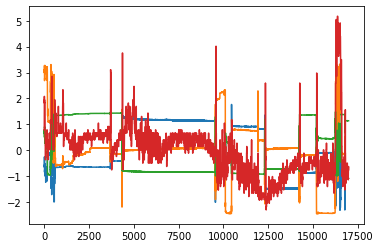

In [388]:
# Visualize signals

lst = [int(i) for i in range(len(df[feature_columns]))]
plt.plot(lst,df_feature.accX)
plt.plot(lst,df_feature.accY)
plt.plot(lst,df_feature.accZ)
plt.plot(lst,df_feature.heartrate)

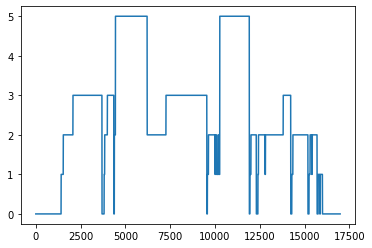

In [389]:
lst = [int(i) for i in range(len(df.heartrate))]
plt.plot(lst,df_label.sleep)

## 9.2.1 Create 3d input

In [390]:
# # ------------ 1D to 3D feature-------------------------------
# # set sliding window parameter
slidingW = 100
n_feature = 4
stride_step = 5
df_feature3D = []
df_label_new = np.array([])                                         
for t in range( 0 , len(df_feature) - 100, stride_step):    
    F3d= df_feature[t:t+ slidingW]                         
    df_feature3D.append(np.array(F3d))        
    Labels = stats.mode(df_label[t : t+slidingW]) 
    df_label_new = np.append(df_label_new,Labels[0])

df_feature3D = np.array(df_feature3D).reshape(len(df_feature3D),100,4,1)

print(df_feature3D.shape)
print(df_label_new.shape)

(3377, 100, 4, 1)
(3377,)


In [406]:
# # ------------ Train-Test-Split 2D features -------------------------------
x_train, x_test, y_train, y_test = train_test_split(df_feature, df_label)


12735 16981


In [392]:
# # ------------ Train-Test-Split 3D features -------------------------------
x3D_train, x3D_test, y3D_train, y3D_test = train_test_split(df_feature3D , df_label_new)

## 9.2 NN Model Train and Test

In [393]:
# ------------ NN Architecture parameter -------------------------------
Hidden_Layer_param = (30, 30, 30)
mlp = MLPClassifier(hidden_layer_sizes = Hidden_Layer_param)
# View NN model parameters

In [394]:
# ------------ Training NN using 1D features -------------------------------
y_train = np.array(y_train).ravel()  ## reshape เป็น (n_sample, ) แก้ตาม warning
y_train.shape
mlp.fit(x_train, y_train)
mlp_pred = mlp.predict(x_test)

In [395]:
# View Confusion Matrix and Classification Report

print('----- Confusion matrix of NN -----')
print(confusion_matrix(y_test,mlp_pred))
print('----- Classification matrix of NN -----')
print(classification_report(y_test,mlp_pred))

----- Confusion matrix of NN -----
[[ 589   23   89   10    1]
 [  25   96  100    6    1]
 [  23   24 1107   67   64]
 [   0    0   53 1115    0]
 [   2    4    3    0  844]]
----- Classification matrix of NN -----
              precision    recall  f1-score   support

         0.0       0.92      0.83      0.87       712
         1.0       0.65      0.42      0.51       228
         2.0       0.82      0.86      0.84      1285
         3.0       0.93      0.95      0.94      1168
         5.0       0.93      0.99      0.96       853

    accuracy                           0.88      4246
   macro avg       0.85      0.81      0.82      4246
weighted avg       0.88      0.88      0.88      4246



## 9.3 CNN Train and Test

#### (a) CNN Model Train Test

In [396]:
# ------------ CNN Architecture parameter -------------------------------
# Nlayer (CNN, dense), Nnode, Activation
CNN_L1 = 16 
CNN_L2 = 64
CNN_L3 = 128
D_L1 = 512
D_out = 6
Activation = "relu"
Ker_size = (3,3)
Pooling_size = (2,1)  
Input_shape = (slidingW, n_feature, 1)  # (100,4,1)
model = Sequential()

In [397]:
 # ------------ Create CNN Model -------------------------------
model.add(Conv2D(CNN_L1, kernel_size=Ker_size, activation=Activation,input_shape=Input_shape,padding='same'))
model.add(MaxPooling2D(pool_size=Pooling_size))                                                                  
model.add(Dropout(0.4))                                                                                          
model.add(Conv2D(CNN_L2, kernel_size=Ker_size, activation= Activation, padding='same'))
model.add(MaxPooling2D(pool_size= Pooling_size))
model.add(Dropout(0.4))
model.add(Conv2D(CNN_L3, kernel_size=Ker_size, activation= Activation, padding='same'))
model.add(MaxPooling2D(pool_size= Pooling_size))
model.add(Dropout(0.4))
model.add(Flatten())                                                                                             
model.add(Dense(D_L1 , activation= Activation ))                                                                 
model.add(Dense(D_out, activation='sigmoid'))                                                                    
model.compile(optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 100, 4, 16)        160       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 50, 4, 16)        0         
 g2D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 50, 4, 16)         0         
                                                                 
 conv2d_34 (Conv2D)          (None, 50, 4, 64)         9280      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 25, 4, 64)        0         
 g2D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, 25, 4, 64)       

In [398]:
# ------------ Create Optimizer -------------------------------
model.compile(optimizer='adam',loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["acc"])

In [399]:
print(x3D_train.shape)
print(np.array(y3D_train).shape)
print(x3D_test.shape)
print(np.array(y3D_test).shape)

(2532, 100, 4, 1)
(2532,)
(845, 100, 4, 1)
(845,)


In [400]:
# ------ Train CNN using 3D feature--------------------------------------------
history = model.fit(x3D_train, y3D_train, epochs=50, batch_size=64,validation_data=(x3D_test, y3D_test)) #batch size load รอไว้ 64 ชุด

Epoch 1/50


2022-11-04 12:07:36.475082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 1.0296 - acc: 0.5620

2022-11-04 12:07:37.641015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 2s 27ms/step - loss: 1.0296 - acc: 0.5620 - val_loss: 0.7445 - val_acc: 0.6959
Epoch 2/50
40/40 [==============================] - 1s 14ms/step - loss: 0.6262 - acc: 0.7362 - val_loss: 0.5321 - val_acc: 0.7728
Epoch 3/50
40/40 [==============================] - 1s 14ms/step - loss: 0.5264 - acc: 0.7757 - val_loss: 0.5079 - val_acc: 0.8213
Epoch 4/50
40/40 [==============================] - 1s 14ms/step - loss: 0.4612 - acc: 0.8013 - val_loss: 0.4233 - val_acc: 0.8438
Epoch 5/50
40/40 [==============================] - 1s 15ms/step - loss: 0.4312 - acc: 0.8152 - val_loss: 0.3997 - val_acc: 0.8592
Epoch 6/50
40/40 [==============================] - 1s 13ms/step - loss: 0.4104 - acc: 0.8187 - val_loss: 0.4035 - val_acc: 0.8462
Epoch 7/50
40/40 [==============================] - 0s 12ms/step - loss: 0.3702 - acc: 0.8472 - val_loss: 0.3534 - val_acc: 0.8639
Epoch 8/50
40/40 [==============================] - 0s 12ms/step - loss: 0.3532 - acc: 0.8511 

In [401]:
# # ------- Test CNN -------------------------------
CNN_pred = np.argmax(model.predict(x3D_test),axis=1)
print(CNN_pred)

27/27 [==============================] - 0s 4ms/step
[2 0 5 0 3 5 5 2 2 2 5 3 2 2 2 2 5 3 2 3 2 3 5 3 3 0 2 5 2 5 1 0 2 5 2 3 2
 3 5 3 2 3 2 2 5 0 5 5 2 5 5 2 2 5 5 0 2 0 2 5 2 3 3 2 2 3 2 3 1 5 3 5 5 1
 3 0 2 3 1 3 2 3 0 3 5 0 5 2 0 3 3 5 2 5 5 2 0 3 0 2 3 0 5 0 3 5 5 3 2 3 3
 2 3 3 2 5 5 2 3 0 2 5 3 5 5 0 1 5 0 5 2 0 0 2 3 5 2 2 2 0 5 2 0 5 2 3 3 2
 3 0 5 2 3 3 5 1 5 2 2 0 5 3 3 2 5 5 3 3 3 5 3 2 0 2 3 2 2 5 5 5 3 3 0 2 0
 3 5 2 5 2 3 2 0 3 2 5 1 2 3 3 2 0 2 0 3 0 5 0 0 5 2 3 2 3 5 2 3 0 5 3 0 3
 2 2 0 3 3 2 5 5 2 5 2 0 3 3 2 2 5 2 3 3 1 2 0 5 3 0 2 3 5 2 0 3 2 1 2 0 5
 2 3 2 5 5 3 3 2 2 1 1 5 2 0 0 3 1 2 2 5 5 2 2 2 0 0 0 5 2 0 5 3 5 5 3 0 5
 5 2 3 5 2 3 5 0 3 5 2 5 3 5 5 0 5 2 2 3 3 2 3 0 2 2 0 2 0 2 2 3 5 2 0 5 3
 2 2 0 0 0 3 2 0 0 3 5 2 2 3 5 5 3 1 0 3 2 2 3 2 5 5 5 0 3 2 2 3 2 3 5 2 5
 2 2 0 2 1 2 3 2 0 0 2 0 3 2 2 5 2 3 0 3 2 5 3 0 3 2 0 2 2 0 3 2 5 2 5 3 3
 3 2 5 3 3 3 3 2 3 3 0 0 1 3 3 2 2 2 3 2 2 5 0 5 0 3 5 3 5 2 2 3 2 0 0 5 2
 5 2 5 0 2 2 2 2 0 2 5 0 3 0 0 2 5 2 3 0 5 2 3 

2022-11-04 12:08:02.690992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


#### 9.3.2 Performance of CNN Model

In [402]:
# ------------ View Confusion Matrix, Classification Report -------------------------------
print('----- Confusion matrix of NN -----')
print(confusion_matrix(y3D_test,CNN_pred))
print('----- Classification matrix of NN -----')
print(classification_report(y3D_test,CNN_pred))

----- Confusion matrix of NN -----
[[123   0   6   0   0]
 [  1  24  13   0   1]
 [  3   1 248  17  10]
 [  2   0   6 209   0]
 [  0   0   0   0 181]]
----- Classification matrix of NN -----
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       129
         1.0       0.96      0.62      0.75        39
         2.0       0.91      0.89      0.90       279
         3.0       0.92      0.96      0.94       217
         5.0       0.94      1.00      0.97       181

    accuracy                           0.93       845
   macro avg       0.94      0.88      0.90       845
weighted avg       0.93      0.93      0.93       845



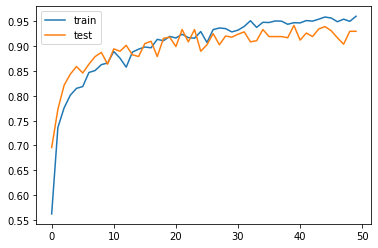

In [403]:
# ------ View Confusion Matrix, Classification Report --------------------------
# --------------- View History Graph -------------------------------------------

# View Accuracy Graph
# summarize history for accuracy
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

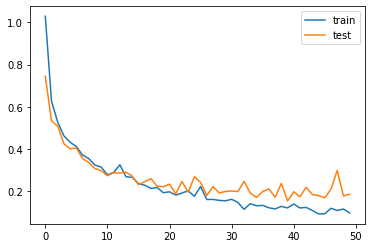

In [404]:
# View Loss Graph
# summarize history for loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()